<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Курс "Глубокое обучение". Первый семестр</b></h3>

# Домашнее задание. Сегментация изображений

#### Выполнил Лаврентьев Кирилл

---


1.Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>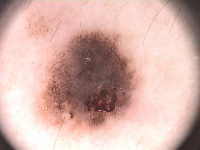</td><td>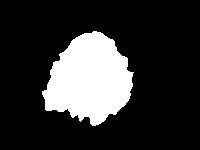</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем сегментировать их.

In [1]:
! wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar

--2020-12-21 18:43:48--  https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/k88qukc20ljnbuo/PH2Dataset.rar [following]
--2020-12-21 18:43:48--  https://www.dropbox.com/s/raw/k88qukc20ljnbuo/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc13da9b2a570cdf058faee30ea4.dl.dropboxusercontent.com/cd/0/inline/BFjUjVMCL2c4ba4pKMcaja7dKMsIW8ciwAfAnsYdVK9ifOS-ABfBadWfSD4iDhrbbXQcV3Rk-9EXr_aJVQ-aBxi14fGlPiqopMnBt2_oAALFkA/file# [following]
--2020-12-21 18:43:49--  https://uc13da9b2a570cdf058faee30ea4.dl.dropboxusercontent.com/cd/0/inline/BFjUjVMCL2c4ba4pKMcaja7dKMsIW8ciwAfAnsYdVK9ifOS-ABfBadWfSD4iDhrbbXQcV3Rk-9EXr_aJVQ-aBxi14fGlPiqopMnBt2_oAALFkA/file
Resolving 

In [2]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

Для загрузки датасета я предлагаю использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [3]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize) можно использовать для изменения размера изображений. 
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [4]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [5]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [6]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

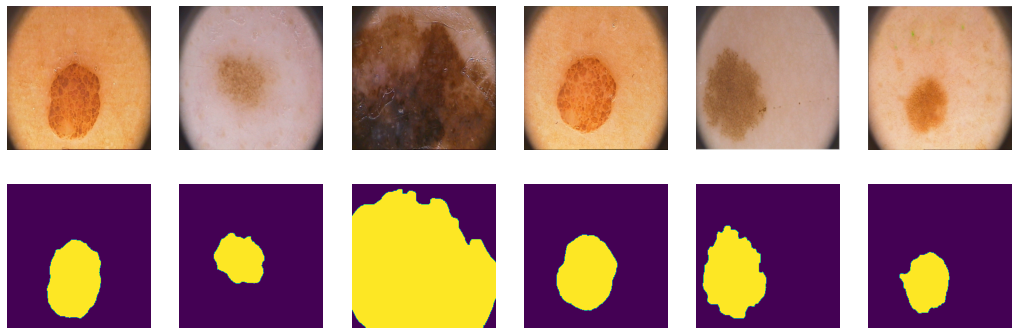

In [7]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для валидации и теста

In [8]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [9]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [10]:
from torch.utils.data import DataLoader
batch_size = 6
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [11]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

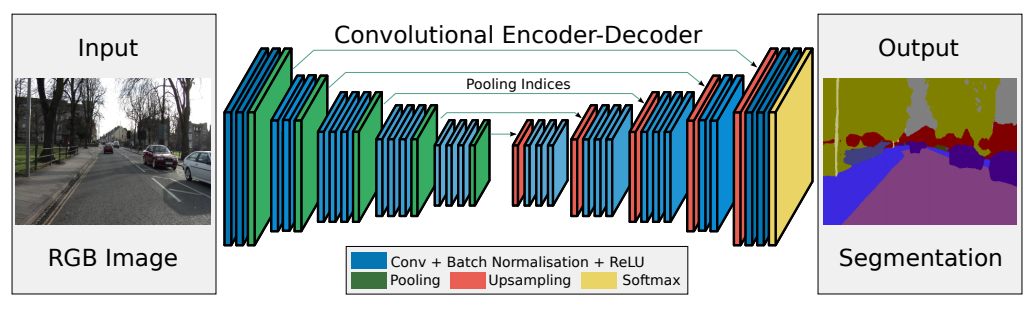

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [13]:
# #Нормально работала модель, но хочу поменять размеры выходов

class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
            # nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        )
        self.bottleneck_pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.bottleneck_upsample = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.bottleneck_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1)
            # nn.BatchNorm2d(1)
        )

    def forward(self, x):
        # encoder
        e0, ind0 = self.pool0(self.enc_conv0(x))
        e1, ind1 = self.pool1(self.enc_conv1(e0))
        e2, ind2 = self.pool2(self.enc_conv2(e1))
        e3, ind3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b0, indb = self.bottleneck_pool(self.bottleneck_conv(e3))
        b = self.bottleneck_conv1(self.bottleneck_upsample(b0, indb))

        # decoder
        d0 = self.dec_conv0(self.upsample0(b, ind3))
        d1 = self.dec_conv1(self.upsample1(d0, ind2))
        d2 = self.dec_conv2(self.upsample2(d1, ind1))
        d3 = self.dec_conv3(self.upsample3(d2, ind0)) # no activation
        return d3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


To clarify this we can see on the segmentation:
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


And the intersection will be the following:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [14]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

## Функция потерь [1 балл]

Теперь не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) в Тарая функция эквивалентна и не так подвержена численной неустойчивости.

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [15]:
def bce_loss(y_real, y_pred):
    # TODO 
    # please don't use nn.BCELoss. write it from scratch
    return torch.mean(y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred)))

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [16]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
        
            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
            del X_batch
            del Y_batch
            del Y_pred
        toc = time()
        print('loss: %f' % avg_loss)

        train_loss_history.append(avg_loss.item())
        val_loss_history.append(eval_epoch(model,data_val,loss_fn).item())

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = (model(X_val.to(device))).cpu().detach().numpy() # detach and put into cpu

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()


In [17]:
def eval_epoch(model, val_loader, criterion):
    avg_loss = 0
    model.eval()

    for X_batch, Y_batch in val_loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)

        with torch.set_grad_enabled(False):
            Y_pred = model(X_batch)
            loss = criterion(Y_batch, Y_pred)
            avg_loss += loss / len(val_loader)

    return avg_loss

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [18]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [19]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = model(X_batch.to(device))
        Y_pred = torch.sigmoid(Y_pred) > 0.5
        #Y_pred = torch.sigmoid(Y_pred).view(-1) # Y_pred = torch.sigmoid(Y_pred) >0.5
        scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [20]:
model = SegNet().to(device)

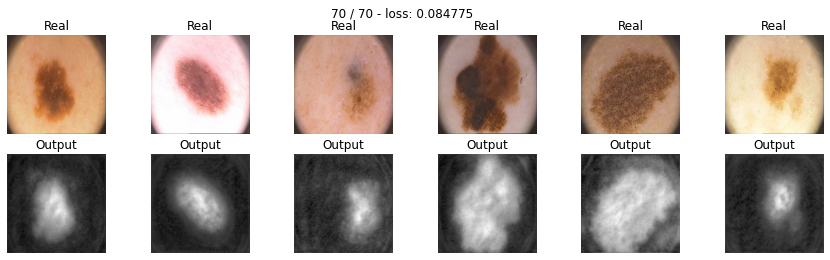

In [21]:
train_loss_history,val_loss_history = [],[]
loss_history = []
history = {}
history.clear()

max_epochs = 70
segnet_opt = torch.optim.Adam(model.parameters())
train(model, segnet_opt, bce_loss, max_epochs, data_tr, data_val)

history = {'SegNet + bcc_loss':[train_loss_history,val_loss_history]}
train_loss_history,val_loss_history = [],[]

In [22]:
val_score = score_model(model, iou_pytorch, data_val)
test_score = score_model(model, iou_pytorch, data_ts)
print('Score на валидации ',val_score)
print('Score на тесте ',test_score)
loss_history.append([val_score,test_score])

Score на валидации  0.6685185366206698
Score на тесте  0.7425926393932767


Ответьте себе на вопрос: не переобучается ли моя модель?

Модель не переобучается

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало, прежде чем бить тревогу попробуйте поперебирать различные варианты, убедитесь, что во всех других сетапах сетть достигает желанного результата. СПОЙЛЕР: учиться она будеет при всех лоссах предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникаемой в математической формуле.


In [23]:
def dice_loss(y_real, y_pred):
    eps = 1e-6
    y_real = y_real.view(-1)
    y_pred = torch.sigmoid(y_pred.view(-1))

    num = torch.sum(y_pred * y_real)
    den = torch.sum(y_real + y_pred)
    res = 1 - 2*num / (den + eps)
    return res 
  
    #res = torch.mean(1 - 1 * (2*num / (den + eps)))# res = 1 - (1 / (256 ** 2)) * num / den
    # res = 1 - (1 / (256 ** 2)) * num / den
    # res = torch.mean(1 - 1 * (2*num / (den + eps)))

Проводим тестирование:

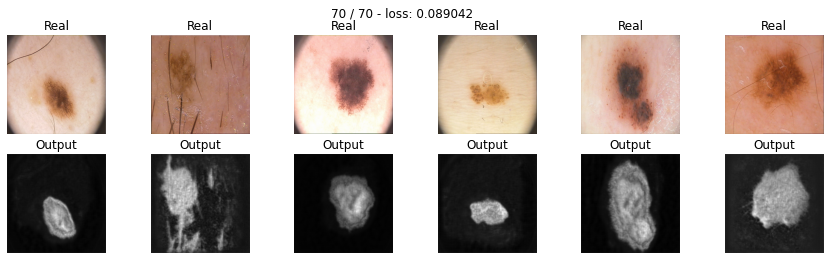

In [24]:
train_loss_history,val_loss_history = [],[]

model_dice = SegNet().to(device)

max_epochs = 70
optimaizer = optim.Adam(model_dice.parameters())
train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val)

history.update({'SegNet + dice_loss':[train_loss_history,val_loss_history]})
train_loss_history,val_loss_history = [],[]

In [25]:
val_score = score_model(model_dice, iou_pytorch, data_val)
test_score = score_model(model_dice, iou_pytorch, data_ts)
print('Score на валидации ',val_score)
print('Score на тесте ',test_score)
loss_history.append([val_score,test_score])

Score на валидации  0.7000000377496084
Score на тесте  0.7444444828563266


[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [26]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    y_pred =  torch.clamp(torch.sigmoid(y_pred), eps, 1 - eps)
    bceLoss = bce_loss(y_real, y_pred)
    p_t = torch.exp(-bceLoss)
    your_loss = ((1 - p_t) ** gamma) * bceLoss

    return your_loss

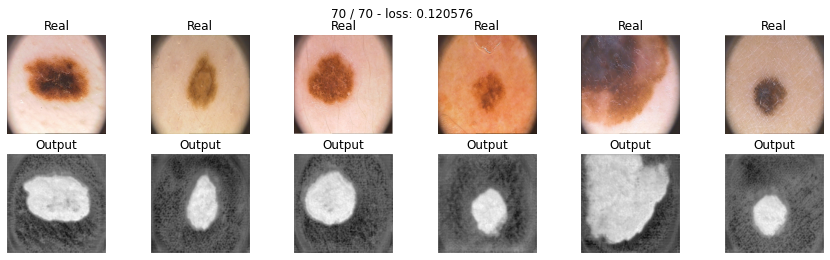

In [27]:
train_loss_history,val_loss_history = [],[]

model_focal = SegNet().to(device)

max_epochs = 70
optimaizer = optim.Adam(model_focal.parameters())
train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val)

history.update({'SegNet + focal_loss':[train_loss_history,val_loss_history]})

train_loss_history,val_loss_history = [],[]

In [28]:
val_score = score_model(model_focal, iou_pytorch, data_val)
test_score = score_model(model_focal, iou_pytorch, data_ts)
print('Score на валидации ',val_score)
print('Score на тесте ',test_score)
loss_history.append([val_score,test_score])

Score на валидации  0.7222222420904372
Score на тесте  0.7407407694392734


----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

In [29]:
#<TODO>

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Учитывая медицинское изображение, он выводит изображение в оттенках серого, представляющее вероятность того, что каждый пиксель является интересующей областью.

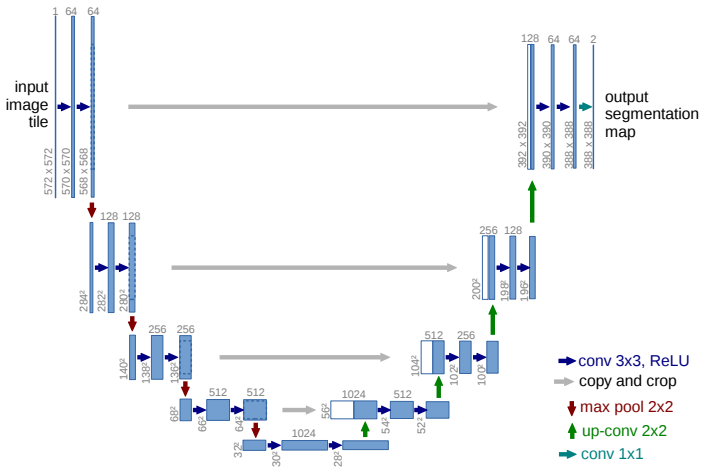

У нас в архитектуре все так же существует енкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются skip-conenctions. Элементы соединяющие части декодера и енкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [30]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.ReplicationPad2d(1),
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ReplicationPad2d(1),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2) # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.ReplicationPad2d(1),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ReplicationPad2d(1),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.ReplicationPad2d(1),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ReplicationPad2d(1),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.ReplicationPad2d(1),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.ReplicationPad2d(1),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.ReplicationPad2d(1),
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.ReplicationPad2d(1),
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)   
        )

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(32) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.upsample1 = nn.Upsample(64) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.upsample2 = nn.Upsample(128)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.upsample3 = nn.Upsample(256)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.dec_conv4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1),
            nn.BatchNorm2d(1)
        )


    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        ep0 = self.pool0(e0)
        e1 = self.enc_conv1(ep0)
        ep1 = self.pool1(e1)
        e2 = self.enc_conv2(ep1)
        ep2 = self.pool2(e2)
        e3 = self.enc_conv3(ep2)
        ep3 = self.pool3(e3)

        # bottleneck
        b = self.bottleneck_conv(ep3)

        # decoder
        d0 = self.dec_conv0(torch.cat((e3, self.upsample0(b)), dim=1))
        d1 = self.dec_conv1(torch.cat((e2, self.upsample1(d0)), dim=1))
        d2 = self.dec_conv2(torch.cat((e1, self.upsample2(d1)), dim=1))
        d3 = self.dec_conv3(torch.cat((e0, self.upsample3(d2)), dim=1))
        d4 = self.dec_conv4(d3) # no activation
        return d4

In [31]:
# Unet + bce_loss
unet_model = UNet().to(device)

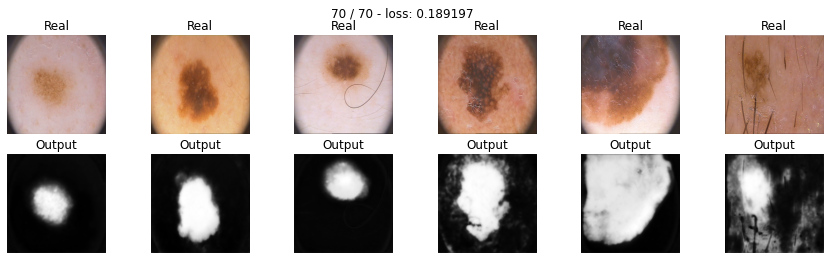

In [32]:
train_loss_history,val_loss_history = [],[]
max_epochs = 70
train(unet_model, optim.Adam(unet_model.parameters()), bce_loss, max_epochs, data_tr, data_val)

history.update({'Unet + bce_loss':[train_loss_history,val_loss_history]})

train_loss_history,val_loss_history = [],[]

In [33]:
val_score = score_model(unet_model, iou_pytorch, data_val)
test_score = score_model(unet_model, iou_pytorch, data_ts)
print('Score на валидации ',val_score)
print('Score на тесте ',test_score)
loss_history.append([val_score,test_score])

Score на валидации  0.7592592967881097
Score на тесте  0.7962963183720907


In [34]:
# Unet model + dice_loss
unet_model = UNet().to(device)

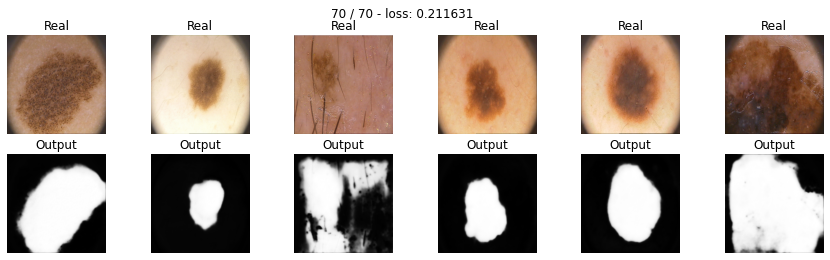

In [35]:
train_loss_history,val_loss_history = [],[]
max_epochs = 70
train(unet_model, optim.Adam(unet_model.parameters()), dice_loss, max_epochs, data_tr, data_val)

history.update({'Unet model + dice_loss':[train_loss_history,val_loss_history]})

train_loss_history,val_loss_history = [],[]

In [36]:
val_score = score_model(unet_model, iou_pytorch, data_val)
test_score = score_model(unet_model, iou_pytorch, data_ts)
print('Score на валидации ',val_score)
print('Score на тесте ',test_score)
loss_history.append([val_score,test_score])

Score на валидации  0.638888912068473
Score на тесте  0.7333333757188585


In [37]:
# Unet model + focal_loss
unet_model = UNet().to(device)

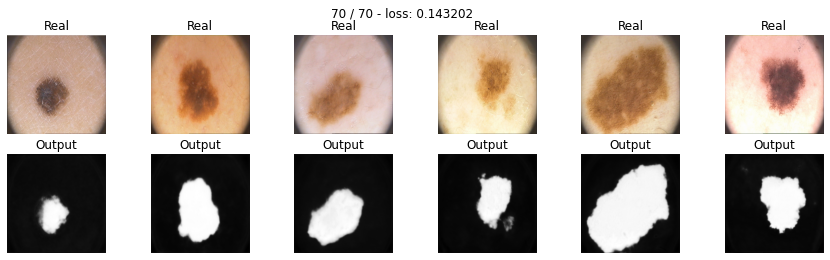

In [38]:
train_loss_history,val_loss_history = [],[]
max_epochs = 70
train(unet_model, optim.Adam(unet_model.parameters()), focal_loss, max_epochs, data_tr, data_val)

history.update({'Unet model + focal_loss':[train_loss_history,val_loss_history]})

train_loss_history,val_loss_history = [],[]

In [39]:
val_score = score_model(unet_model, iou_pytorch, data_val)
test_score = score_model(unet_model, iou_pytorch, data_ts)
print('Score на валидации ',val_score)
print('Score на тесте ',test_score)
loss_history.append([val_score,test_score])

Score на валидации  0.7481481962733798
Score на тесте  0.8240741160180833


Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [40]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.ReplicationPad2d(1),
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ReplicationPad2d(1),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.pool0 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, stride=2) # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.ReplicationPad2d(1),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ReplicationPad2d(1),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=2, stride=2) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.ReplicationPad2d(1),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ReplicationPad2d(1),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=2, stride=2) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.ReplicationPad2d(1),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.ReplicationPad2d(1),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.pool3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=2, stride=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.ReplicationPad2d(1),
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.ReplicationPad2d(1),
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)   
        )

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=2, stride=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.upsample1 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.upsample2 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.upsample3 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.dec_conv4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1),
            nn.BatchNorm2d(1)
        )


    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        ep0 = self.pool0(e0)
        e1 = self.enc_conv1(ep0)
        ep1 = self.pool1(e1)
        e2 = self.enc_conv2(ep1)
        ep2 = self.pool2(e2)
        e3 = self.enc_conv3(ep2)
        ep3 = self.pool3(e3)

        # bottleneck
        b = self.bottleneck_conv(ep3)

        # decoder
        d0 = self.dec_conv0(torch.cat((e3, self.upsample0(b)), dim=1))
        d1 = self.dec_conv1(torch.cat((e2, self.upsample1(d0)), dim=1))
        d2 = self.dec_conv2(torch.cat((e1, self.upsample2(d1)), dim=1))
        d3 = self.dec_conv3(torch.cat((e0, self.upsample3(d2)), dim=1))
        d4 = self.dec_conv4(d3) # no activation
        return d4

In [41]:
# Unet2 + bcc_loss

unet2_model = UNet2().to(device)

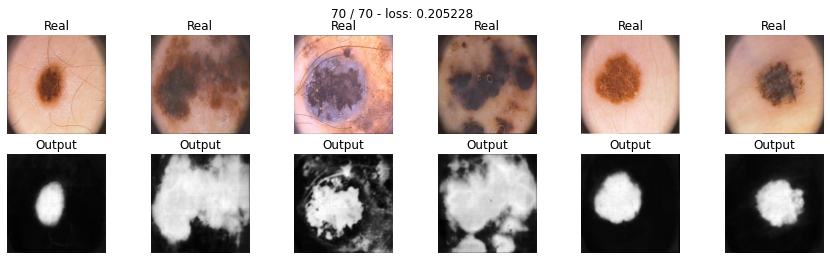

In [42]:
train_loss_history,val_loss_history = [],[]
max_epochs = 70
train(unet2_model, optim.Adam(unet2_model.parameters()), bce_loss, max_epochs, data_tr, data_val)

history.update({'Unet2 + bcc_loss':[train_loss_history,val_loss_history]})

train_loss_history,val_loss_history = [],[]

In [43]:
val_score = score_model(unet2_model, iou_pytorch, data_val)
test_score = score_model(unet2_model, iou_pytorch, data_ts)
print('Score на валидации ',val_score)
print('Score на тесте ',test_score)
loss_history.append([val_score,test_score])

Score на валидации  0.6351852085855272
Score на тесте  0.6481481790542603


In [44]:
# Unet2 + dice_loss

unet2_model = UNet2().to(device)

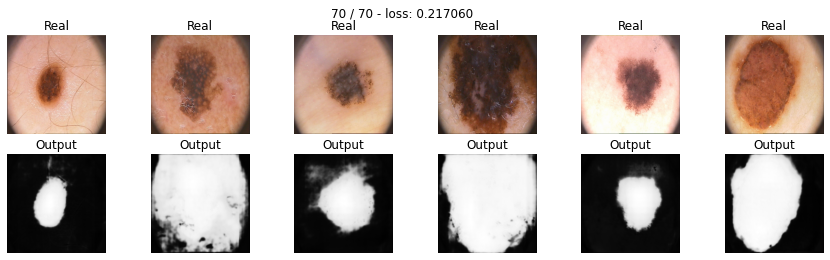

In [45]:
train_loss_history,val_loss_history = [],[]
max_epochs = 70
train(unet2_model, optim.Adam(unet2_model.parameters()), dice_loss, max_epochs, data_tr, data_val)

history.update({'Unet2 + dice_loss':[train_loss_history,val_loss_history]})

train_loss_history,val_loss_history = [],[]

In [46]:
val_score = score_model(unet2_model, iou_pytorch, data_val)
test_score = score_model(unet2_model, iou_pytorch, data_ts)
print('Score на валидации ',val_score)
print('Score на тесте ',test_score)
loss_history.append([val_score,test_score])

Score на валидации  0.5629629890124003
Score на тесте  0.5222222490443124


In [47]:
# Unet2 + focal_loss

unet2_model = UNet2().to(device)

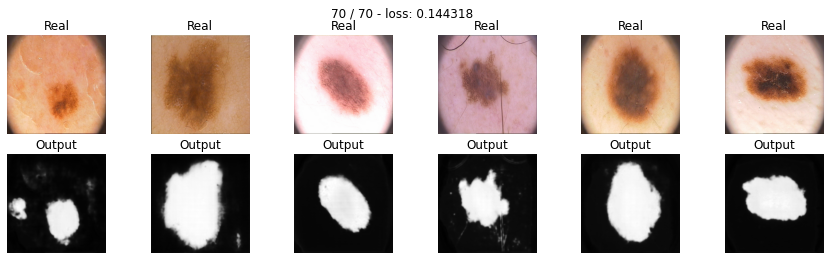

In [48]:
train_loss_history,val_loss_history = [],[]
max_epochs = 70
train(unet2_model, optim.Adam(unet2_model.parameters()), focal_loss, max_epochs, data_tr, data_val)

history.update({'Unet2 + focal_loss':[train_loss_history,val_loss_history]})

train_loss_history,val_loss_history = [],[]

In [49]:
val_score = score_model(unet2_model, iou_pytorch, data_val)
test_score = score_model(unet2_model, iou_pytorch, data_ts)
print('Score на валидации ',val_score)
print('Score на тесте ',test_score)
loss_history.append([val_score,test_score])

Score на валидации  0.727777812216017
Score на тесте  0.772222273879581


Сделайте вывод какая из моделей лучше

# Отчет (6 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии: 

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.

## Отчёт по заданию

После обучения хочется увидеть, как обучалась каждая модель по отдельности. Посмотрим это на следующих графиках. Видно, что модели не переобучаются и loss у всех уменьшается с количеством эпох, постепенно приближаясь к ассимптоте снизу.

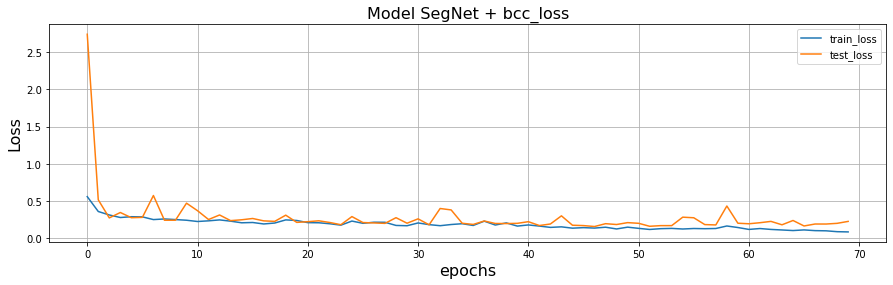

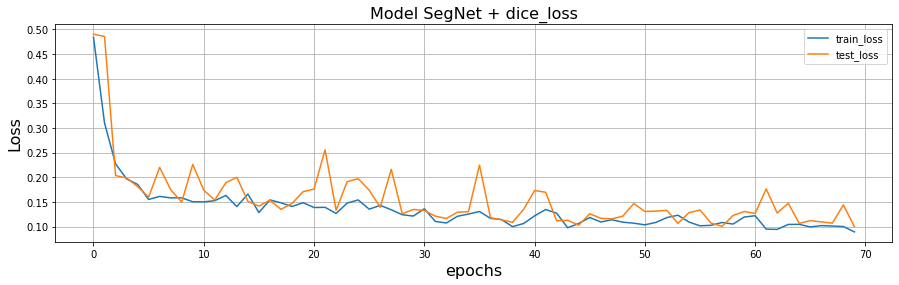

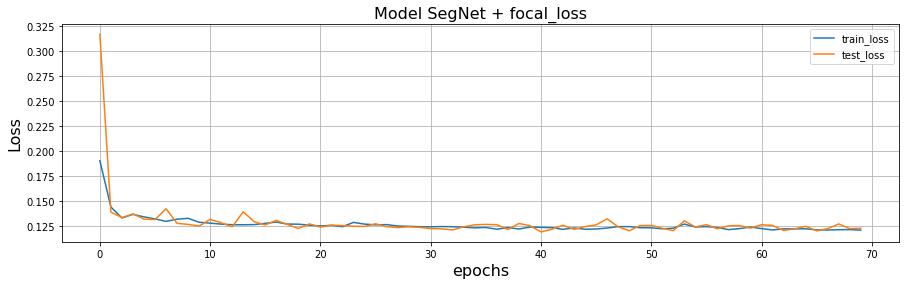

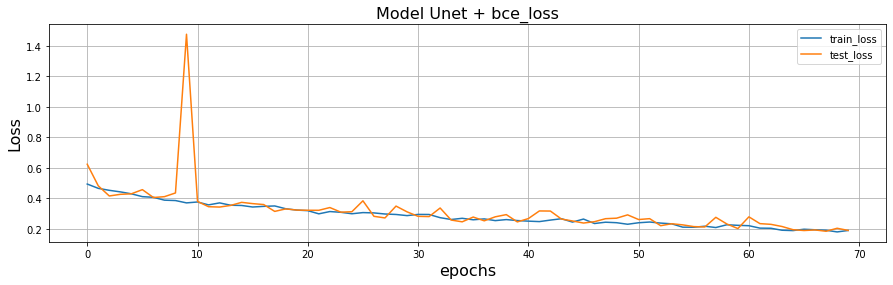

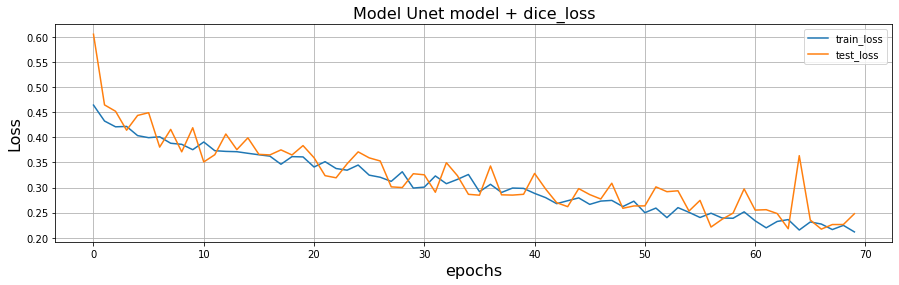

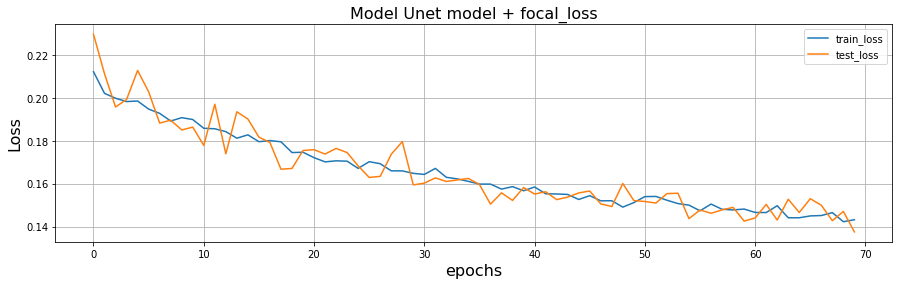

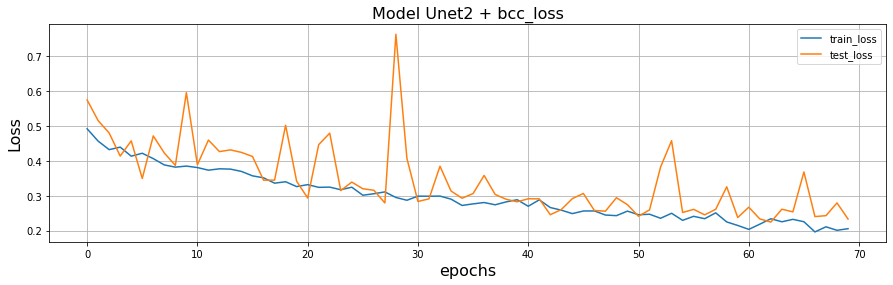

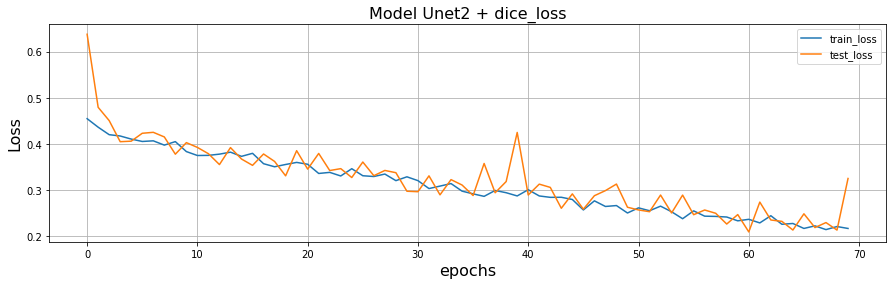

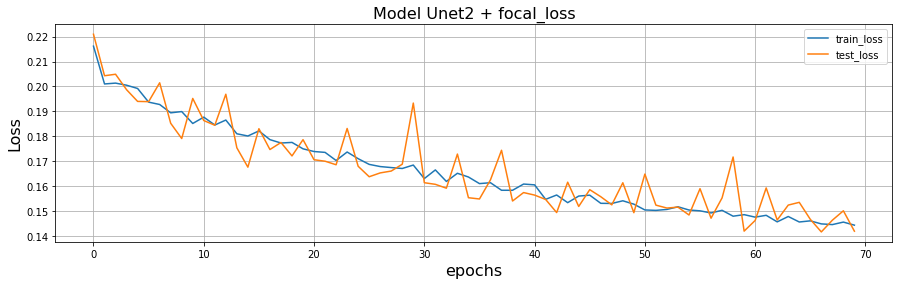

In [54]:
models = ['SegNet + bcc_loss','SegNet + dice_loss','SegNet + focal_loss',
          'Unet + bce_loss','Unet model + dice_loss','Unet model + focal_loss',
          'Unet2 + bcc_loss','Unet2 + dice_loss','Unet2 + focal_loss']

fig = plt.figure()

for name_col in models:
    loss_1 = history[name_col][0]
    val_loss_1 = history[name_col][1]

    plt.subplot()
    plt.plot(loss_1, label="train_loss")
    plt.plot(val_loss_1, label="test_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs",fontsize=16)
    plt.ylabel("Loss",fontsize=16)
    plt.title('Model {}'.format(name_col),fontsize=16)
    plt.grid()
    plt.show()

Из отдельных графиков выше трудно понять, какая модель в итоге достигает наименьшего loss, поэтому сравним loss моделей на тесте на одном графике. 

<!--  -->

<Figure size 1080x288 with 0 Axes>

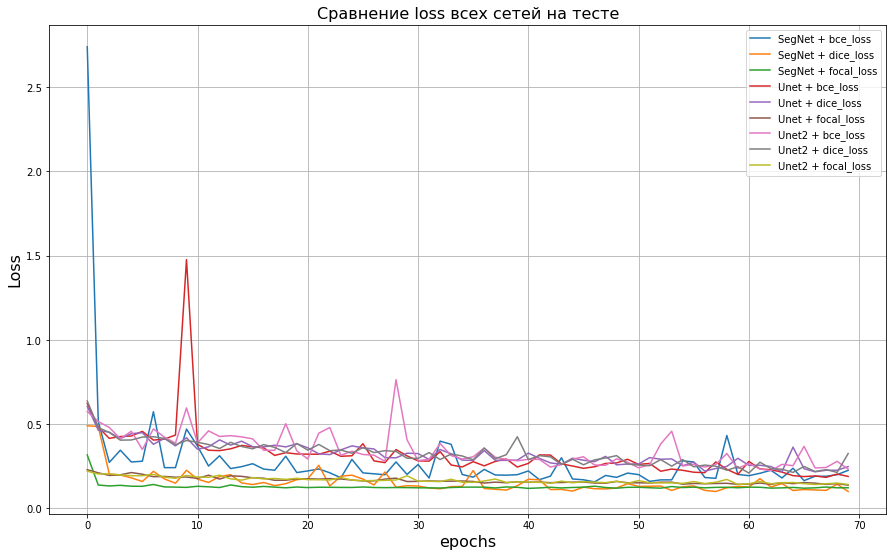

In [56]:
models = ['SegNet + bcc_loss','SegNet + dice_loss','SegNet + focal_loss',
          'Unet + bcc_loss','Unet + dice_loss','Unet + focal_loss',
          'Unet2 + bcc_loss','Unet2 + dice_loss','Unet2 + focal_loss']

fig = plt.figure()

plt.subplots(figsize=(15, 9))
plt.plot(history['SegNet + bcc_loss'][1], label="SegNet + bce_loss")
plt.plot(history['SegNet + dice_loss'][1], label="SegNet + dice_loss")
plt.plot(history['SegNet + focal_loss'][1], label="SegNet + focal_loss")

plt.plot(history['Unet + bce_loss'][1], label="Unet + bce_loss")
plt.plot(history['Unet model + dice_loss'][1], label="Unet + dice_loss")
plt.plot(history['Unet model + focal_loss'][1], label="Unet + focal_loss")

plt.plot(history['Unet2 + bcc_loss'][1], label="Unet2 + bce_loss")
plt.plot(history['Unet2 + dice_loss'][1], label="Unet2 + dice_loss")
plt.plot(history['Unet2 + focal_loss'][1], label="Unet2 + focal_loss")


plt.legend(loc='best')
plt.xlabel("epochs",fontsize=16)
plt.ylabel("Loss",fontsize=16)
plt.grid()
plt.title('Сравнение loss всех сетей на тесте',fontsize=16)
plt.show()

На этом графике трудно разглядеть какая модель имеет наименьший loss. Поэтому, во-первых, построим графики отдельно для каждой архитектуры модели (SegNet, Unet, Unet2), а во-вторых уберем явный выброс на графике для **SegNet + bcc_loss**, чтобы можно было лучше наблюдать loss всех моделей.

<Figure size 1080x288 with 0 Axes>

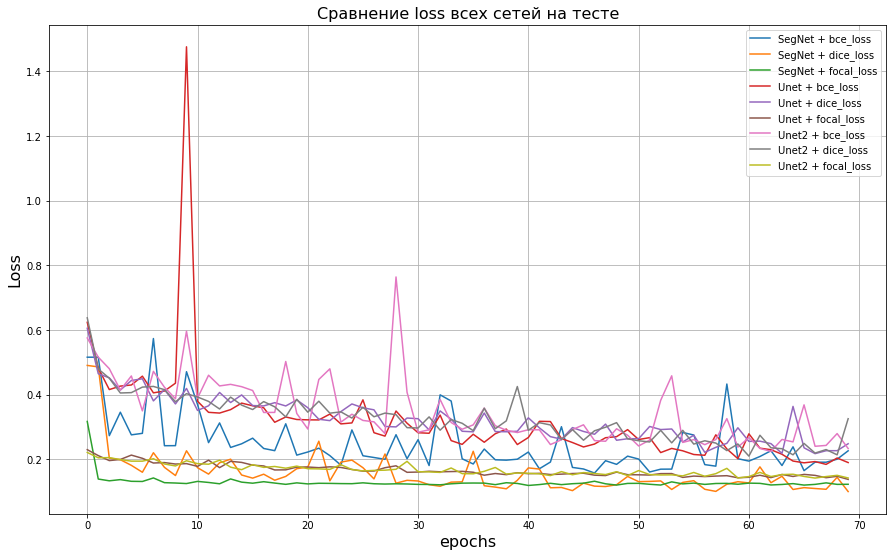

In [62]:
fig = plt.figure()

plt.subplots(figsize=(15, 9))

# Убираем случайный выброс
history['SegNet + bcc_loss'][1][0] = history['SegNet + bcc_loss'][1][1] 

plt.plot(history['SegNet + bcc_loss'][1], label="SegNet + bce_loss")
plt.plot(history['SegNet + dice_loss'][1], label="SegNet + dice_loss")
plt.plot(history['SegNet + focal_loss'][1], label="SegNet + focal_loss")

plt.plot(history['Unet + bce_loss'][1], label="Unet + bce_loss")
plt.plot(history['Unet model + dice_loss'][1], label="Unet + dice_loss")
plt.plot(history['Unet model + focal_loss'][1], label="Unet + focal_loss")

plt.plot(history['Unet2 + bcc_loss'][1], label="Unet2 + bce_loss")
plt.plot(history['Unet2 + dice_loss'][1], label="Unet2 + dice_loss")
plt.plot(history['Unet2 + focal_loss'][1], label="Unet2 + focal_loss")


plt.legend(loc='best')
plt.xlabel("epochs",fontsize=16)
plt.ylabel("Loss",fontsize=16)
plt.grid()
plt.title('Сравнение loss всех сетей на тесте',fontsize=16)
plt.show()

Теперь видно, что лучше всего себя показывают модели с функцией потерь **focal_loss**. Далее посмотрим на одинаковые модели с разными функциями потерь.

<Figure size 1080x288 with 0 Axes>

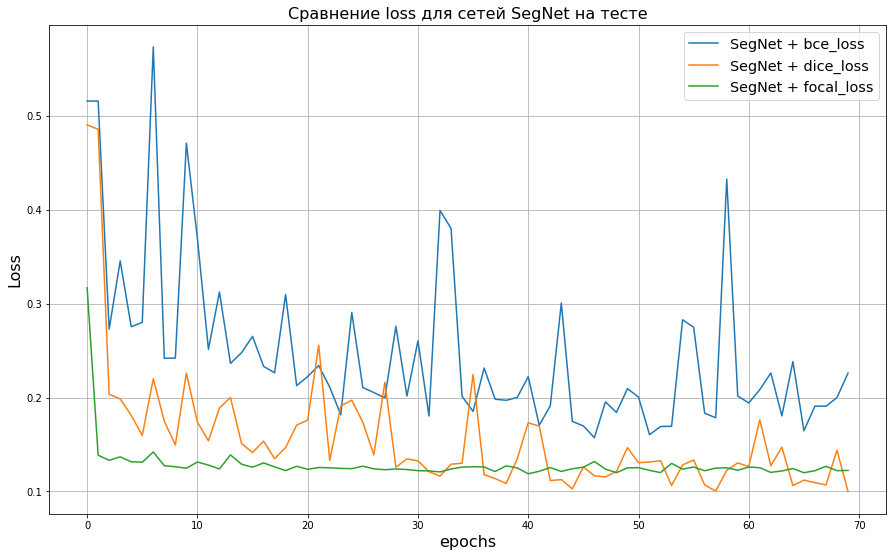

In [65]:
fig = plt.figure()

plt.subplots(figsize=(15, 9))
plt.plot(history['SegNet + bcc_loss'][1], label="SegNet + bce_loss")
plt.plot(history['SegNet + dice_loss'][1], label="SegNet + dice_loss")
plt.plot(history['SegNet + focal_loss'][1], label="SegNet + focal_loss")

plt.legend(loc='best',fontsize = 'x-large')
plt.xlabel("epochs",fontsize=16)
plt.ylabel("Loss",fontsize=16)
plt.grid()
plt.title('Сравнение loss для сетей SegNet на тесте',fontsize=16)
plt.show()

<Figure size 1080x288 with 0 Axes>

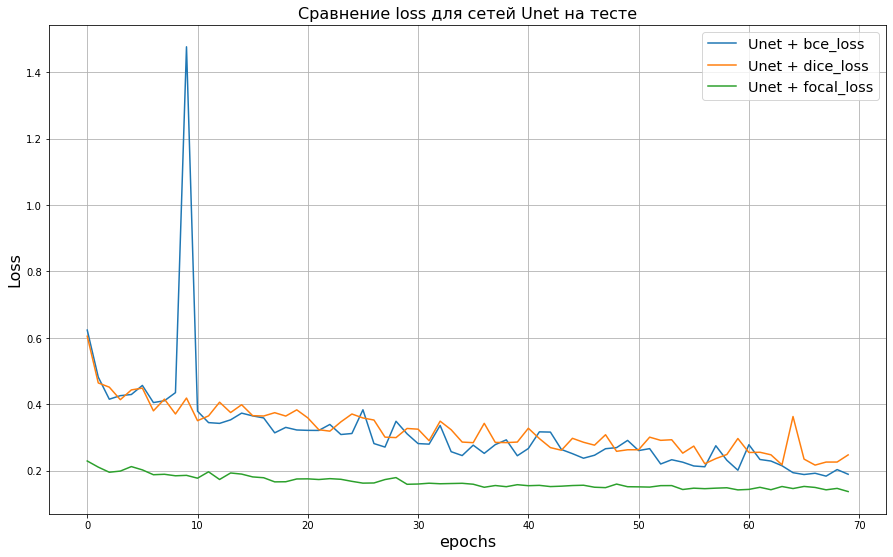

In [66]:
fig = plt.figure()

plt.subplots(figsize=(15, 9))

plt.plot(history['Unet + bce_loss'][1], label="Unet + bce_loss")
plt.plot(history['Unet model + dice_loss'][1], label="Unet + dice_loss")
plt.plot(history['Unet model + focal_loss'][1], label="Unet + focal_loss")

plt.legend(loc='best',fontsize = 'x-large')
plt.xlabel("epochs",fontsize=16)
plt.ylabel("Loss",fontsize=16)
plt.grid()
plt.title('Сравнение loss для сетей Unet на тесте',fontsize=16)
plt.show()

<Figure size 1080x288 with 0 Axes>

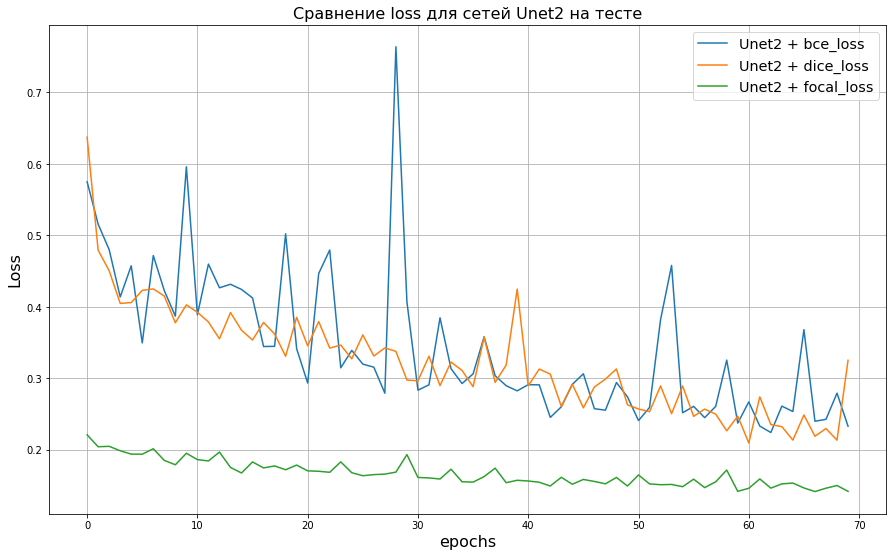

In [67]:
fig = plt.figure()

plt.subplots(figsize=(15, 9))

plt.plot(history['Unet2 + bcc_loss'][1], label="Unet2 + bce_loss")
plt.plot(history['Unet2 + dice_loss'][1], label="Unet2 + dice_loss")
plt.plot(history['Unet2 + focal_loss'][1], label="Unet2 + focal_loss")


plt.legend(loc='best',fontsize = 'x-large')
plt.xlabel("epochs",fontsize=16)
plt.ylabel("Loss",fontsize=16)
plt.grid()
plt.title('Сравнение loss для сетей Unet2 на тесте',fontsize=16)
plt.show()

Ещё раз убеждаемся, что **focal_loss** даёт наименьший loss для каждой рассмотренной модели.

Посмотрим на score и выявим лучшую модель.

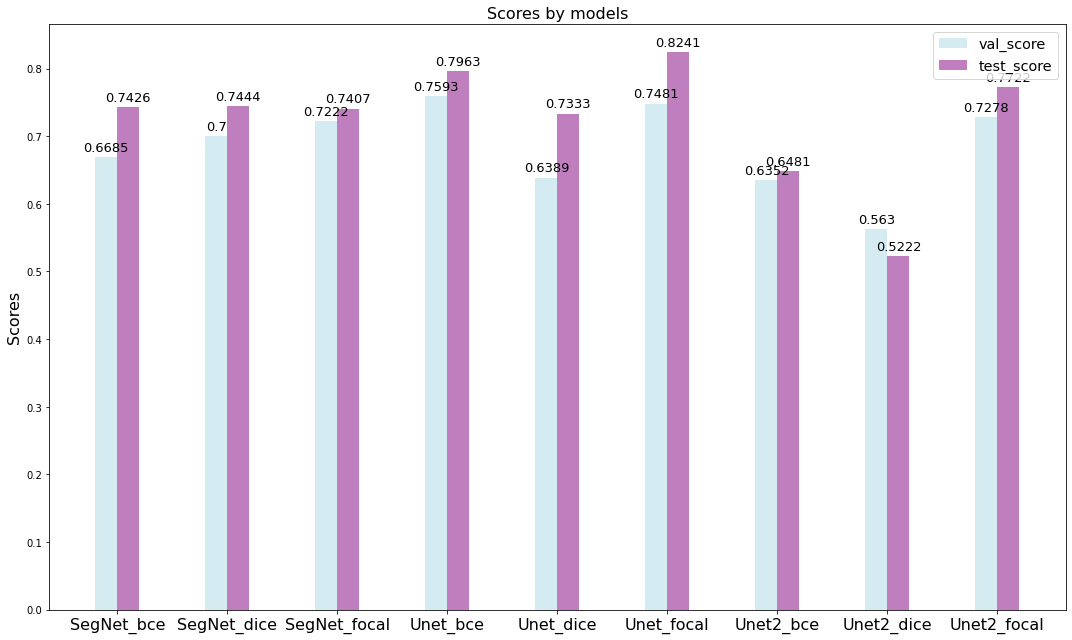

In [80]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = ['SegNet_bce','SegNet_dice','SegNet_focal',
          'Unet_bce','Unet_dice','Unet_focal',
          'Unet2_bce','Unet2_dice','Unet2_focal']

val_score,test_score = [],[]

for i in loss_history:
    val_score.append(i[0])
    test_score.append(i[1])

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 9))
rects1 = ax.bar(x - width/2, val_score, width, label='val_score',color = 'lightblue',alpha=0.5)
rects2 = ax.bar(x + width/2, test_score, width, label='test_score',color = 'purple',alpha=0.5)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores',fontsize=16)
ax.set_title('Scores by models',fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(labels,fontsize=16)
ax.legend(loc='best',fontsize='x-large')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = round(rect.get_height(),4)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',fontsize=13)


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

Лучший score показала архитектура Unet с функцией потерь **focal_loss**. На втором месте идёт также Unet c лосс функцией **bce_loss**.

## Вывод

Для сегментации изображений `PH2 Dataset images` лучше всего подходит архитектура UNet с функцией потерь **focal_loss**.